In [1]:
from features import (load_and_split_data, preprocess_features, select_features, get_feature_importance_names,FEATURE_NAMES)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
train_df, test_df = load_and_split_data()
train_processed = preprocess_features(train_df,is_training=True)
test_processed = preprocess_features(test_df,is_training=False)

print(f"\nProcessed data shapes:")
print(f"Train: {train_processed.shape}")
print(f"Test: {test_processed.shape}")

if 'churn' in train_processed.columns:
    selected_df, selected_features = select_features(train_processed, k=15)
    print(f"\nSelected features shape: {selected_df.shape}")
    top_features, importance_df = get_feature_importance_names(train_processed, top_n=10)
    print(f"\nTop 10 important features identified")
    print(top_features)


2025-09-06 16:23:28,119 - features - INFO - Database connection closed


Data split completed - Train: 5634, Test: 1409

Processed data shapes:
Train: (5634, 31)
Test: (1409, 31)

Selected features shape: (5634, 16)
Top Feature Importances:
totalcharges: 0.1387
monthlycharges: 0.1317
charges_per_tenure: 0.1249
tenure_year: 0.1207
is_month_to_month: 0.0459
has_long_contract: 0.0456
service_bundle_score: 0.0356
internetservice_Fiber_optic: 0.0328
gender: 0.0243
tenure_segment: 0.0232

Top 10 important features identified
['totalcharges', 'monthlycharges', 'charges_per_tenure', 'tenure_year', 'is_month_to_month', 'has_long_contract', 'service_bundle_score', 'internetservice_Fiber_optic', 'gender', 'tenure_segment']


In [3]:
X_train = train_processed.drop(columns=['churn'])
y_train = train_processed['churn']
X_test = test_processed.drop(columns=['churn'])
y_test = test_processed['churn']

In [4]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train,y_train)
print(y_train_res.value_counts())

churn
0    4139
1    4139
Name: count, dtype: int64


In [5]:
rf_model_baseline = RandomForestClassifier(
    n_estimators=100, 
    random_state=42)
rf_model_baseline.fit(X_train_res, y_train_res)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
xgb_model_baseline = XGBClassifier(
    n_estimators=100,
    verbosity=0, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42)
xgb_model_baseline.fit(X_train_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
lgbm_model_baseline = LGBMClassifier(
    n_estimators=100, 
    learning_rate=0.05, 
    random_state=42)
lgbm_model_baseline.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2221
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def model_evaluation(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"model evaluation: {name}\n")

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Prediction")
    plt.ylabel("Real Value")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve - {name}')
    plt.grid()
    plt.show

model evaluation: Random Forest

Accuracy: 0.7786

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1035
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



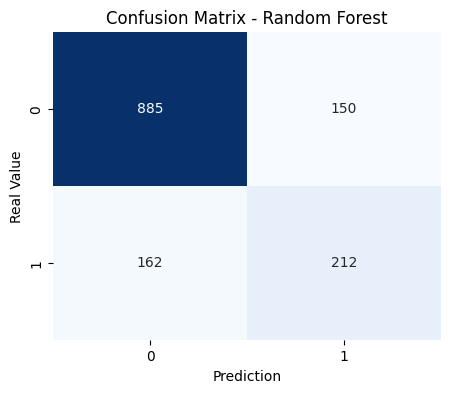

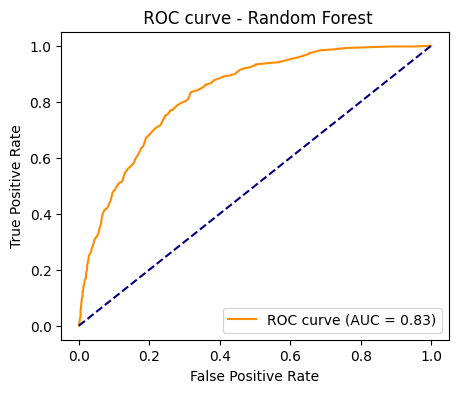

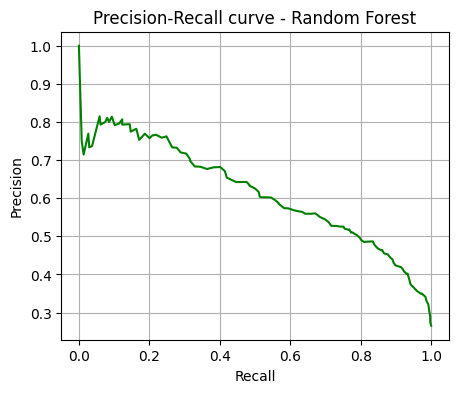

In [9]:
model_evaluation("Random Forest", rf_model_baseline, X_test, y_test)


model evaluation: XGBoost

Accuracy: 0.7736

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1035
           1       0.58      0.56      0.57       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



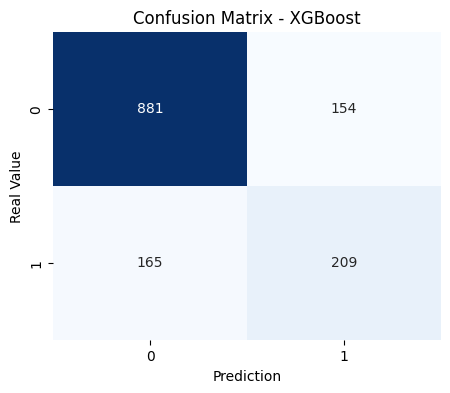

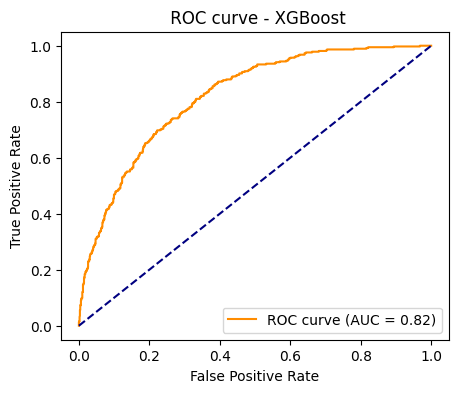

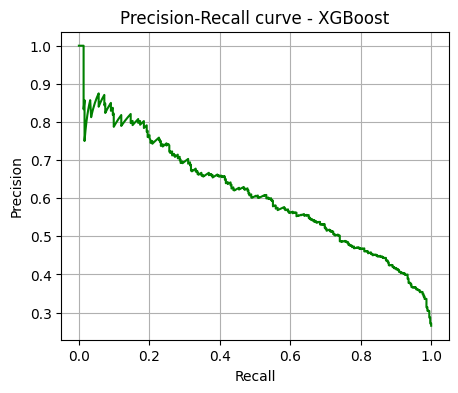

In [10]:
model_evaluation("XGBoost", xgb_model_baseline, X_test, y_test)

model evaluation: LightGBM

Accuracy: 0.7786

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.58      0.59      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



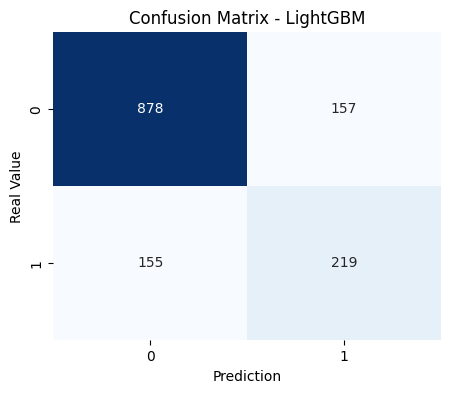

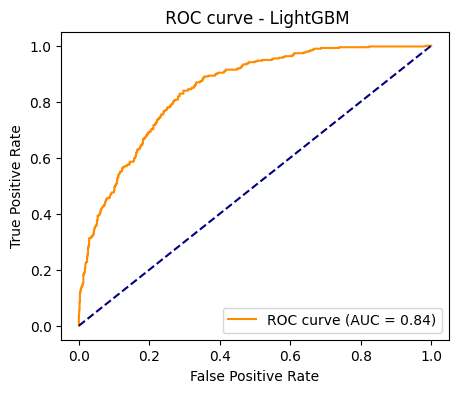

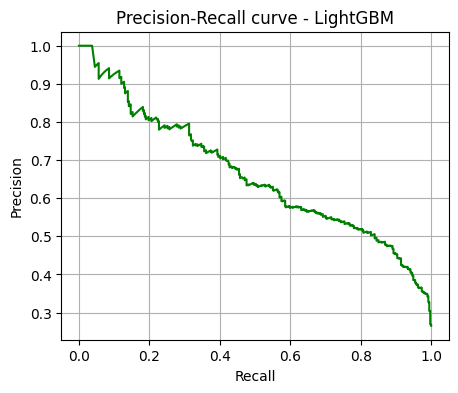

In [11]:
model_evaluation("LightGBM", lgbm_model_baseline, X_test, y_test)

In [12]:
# RandomSearchCV for RandomForest Model
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, recall_score, f1_score


churn_recall_scorer = make_scorer(recall_score, pos_label=1)
churn_f1_scorer = make_scorer(f1_score, pos_label=1)

param_rf = {
    'n_estimators': randint(100,500),
    'max_depth': randint(3,20),
    'min_samples_split': randint(2,20),
    'min_samples_leaf': randint(1,10),
    'bootstrap': [True,False],
    'random_state': [42],
    'class_weight': ['balanced','balanced_subsample']
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_model_baseline,
    param_distributions=param_rf,
    n_iter=20,
    cv=5,
    scoring={
        'churn_recall': churn_recall_scorer,
        'churn_f1': churn_f1_scorer,
        'f1_weighted': "f1_weighted",
        'precision_macro': "precision_macro",
        'accuracy': "accuracy"
    },
    refit= 'churn_recall',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train_res,y_train_res)

print("Best hyperparameters:", rf_random_search.best_params_)
print(f"Best churn recall score: {rf_random_search.best_score_:.4f}")

# Get detailed results for the best model
results = rf_random_search.cv_results_
best_index = rf_random_search.best_index_

print(f"\nAll metrics for best model:")
print(f"Churn Recall: {results['mean_test_churn_recall'][best_index]:.4f} (+/- {results['std_test_churn_recall'][best_index]*2:.4f})")
print(f"Churn F1: {results['mean_test_churn_f1'][best_index]:.4f} (+/- {results['std_test_churn_f1'][best_index]*2:.4f})")
print(f"F1 Weighted: {results['mean_test_f1_weighted'][best_index]:.4f} (+/- {results['std_test_f1_weighted'][best_index]*2:.4f})")
print(f"Precision Macro: {results['mean_test_precision_macro'][best_index]:.4f} (+/- {results['std_test_precision_macro'][best_index]*2:.4f})")
print(f"Accuracy: {results['mean_test_accuracy'][best_index]:.4f} (+/- {results['std_test_accuracy'][best_index]*2:.4f})")

# Save the best model
rf_model_optimized = rf_random_search.best_estimator_

print(f"\nTraining time per model: ~{rf_random_search.cv_results_['mean_fit_time'][best_index]:.2f} seconds")
print(f"Total search time: ~{sum(rf_random_search.cv_results_['mean_fit_time']):.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 11, 'n_estimators': 359, 'random_state': 42}
Best churn recall score: 0.8886

All metrics for best model:
Churn Recall: 0.8886 (+/- 0.1832)
Churn F1: 0.8249 (+/- 0.0810)
F1 Weighted: 0.8126 (+/- 0.0634)
Precision Macro: 0.8277 (+/- 0.0846)
Accuracy: 0.8142 (+/- 0.0653)

Training time per model: ~5.92 seconds
Total search time: ~153.12 seconds


model evaluation: RandomForest with RandomizedSearchCV

Accuracy: 0.7452

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.51      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.75      0.76      1409



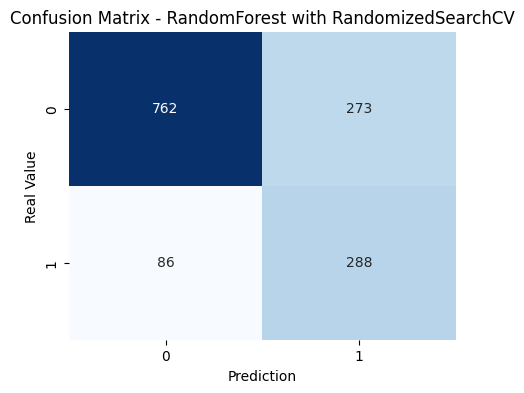

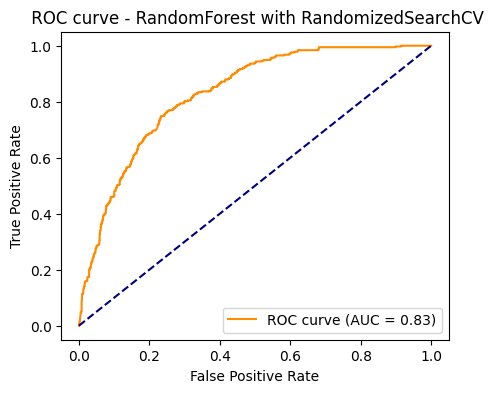

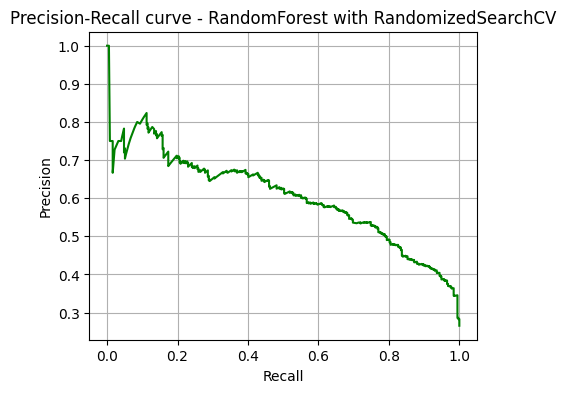

In [54]:
model_evaluation("RandomForest with RandomizedSearchCV", rf_model_optimized, X_test, y_test)

In [28]:
# GridSearchCV for RandomForest
rf_param_grid = {
    'n_estimators': [350,400,450],
    'max_depth': [15,20],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced',{0:1,1:3}],
    'bootstrap': [True]
}

rf_grid_search = GridSearchCV(
    estimator=rf_model_baseline,
    param_grid=rf_param_grid,
    cv=5,
    scoring={
        'churn_recall': churn_recall_scorer,
        'churn_f1': churn_f1_scorer,
        'f1_weighted': "f1_weighted",
        'precision_macro': "precision_macro"
    },
    refit='churn_f1',
    verbose=2,
    n_jobs=-1
)

rf_grid_search.fit(X_train_res, y_train_res)

print("Best hyperparameters:", rf_grid_search.best_params_)
print(f"Best churn recall score: {rf_grid_search.best_score_:.4f}")

# Get detailed results
coarse_results = rf_grid_search.cv_results_
coarse_best_idx = rf_grid_search.best_index_

print(f"\nAll metrics for best coarse model:")
print(f"Churn Recall: {coarse_results['mean_test_churn_recall'][coarse_best_idx]:.4f} (+/- {coarse_results['std_test_churn_recall'][coarse_best_idx]*2:.4f})")
print(f"Churn F1: {coarse_results['mean_test_churn_f1'][coarse_best_idx]:.4f} (+/- {coarse_results['std_test_churn_f1'][coarse_best_idx]*2:.4f})")
print(f"F1 Weighted: {coarse_results['mean_test_f1_weighted'][coarse_best_idx]:.4f}")
print(f"Precision Macro: {coarse_results['mean_test_precision_macro'][coarse_best_idx]:.4f}")

# Save the best model
rf_grid_optimized = rf_grid_search.best_estimator_

print(f"\nTraining time per model: ~{rf_grid_search.cv_results_['mean_fit_time'][best_index]:.2f} seconds")
print(f"Total search time: ~{sum(rf_grid_search.cv_results_['mean_fit_time']):.2f} seconds")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'bootstrap': True, 'class_weight': {0: 1, 1: 3}, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 450}
Best churn recall score: 0.8395

All metrics for best coarse model:
Churn Recall: 0.8787 (+/- 0.2774)
Churn F1: 0.8395 (+/- 0.1269)
F1 Weighted: 0.8373
Precision Macro: 0.8534

Training time per model: ~13.54 seconds
Total search time: ~539.42 seconds


model evaluation: RandomForest with Grid

Accuracy: 0.7665

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



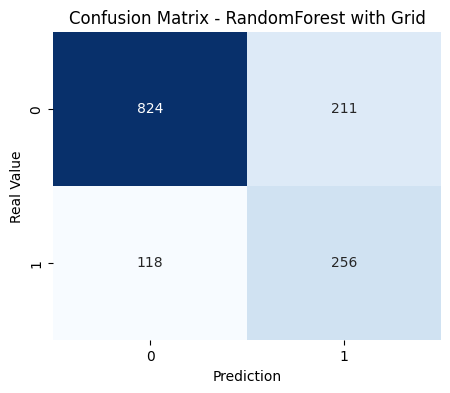

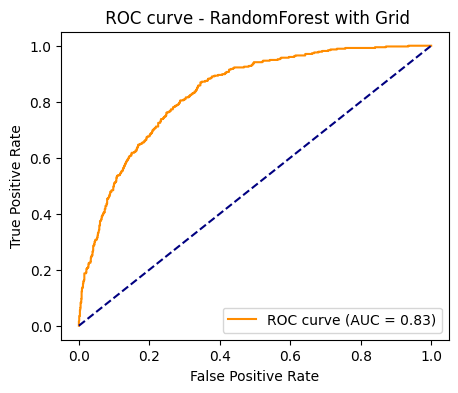

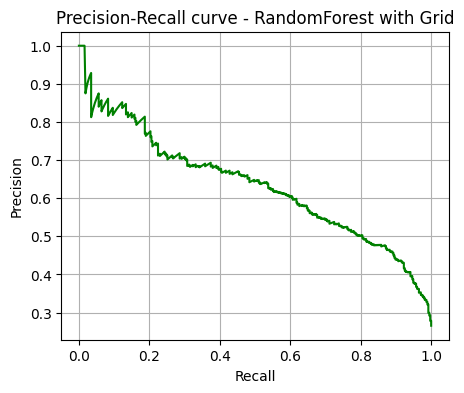

In [52]:
model_evaluation("RandomForest with Grid", rf_grid_optimized, X_test, y_test)

In [22]:
from sklearn.metrics import precision_score

churn_recall_scorer = make_scorer(recall_score, pos_label=1)
churn_f1_scorer = make_scorer(f1_score, pos_label=1)
churn_precision_scorer = make_scorer(precision_score, pos_label=1)

param_xgb = {
    'n_estimators': randint(300, 600),
    'max_depth': randint(6, 12),
    'learning_rate': uniform(0.1, 0.2),
    'min_child_weight': randint(1,5),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'reg_alpha': uniform(0,2),
    'reg_lambda': uniform(1,3),
    'scale_pos_weight': uniform(2,3),
    'random_state': [42]
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model_baseline,
    param_distributions=param_xgb,
    n_iter=30,
    cv=5,
    scoring={
        'churn_recall': churn_recall_scorer,
        'churn_f1': churn_f1_scorer,
        'roc_auc': "roc_auc"
    },
    refit='churn_f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
xgb_random_search.fit(X_train_res, y_train_res)

print("Best hyperparameters:", xgb_random_search.best_params_)
print(f"Best churn F1 score: {xgb_random_search.best_score_:.4f}")

focused_results = xgb_random_search.cv_results_
focused_best_idx = xgb_random_search.best_index_

print(f"\nFocused model metrics:")
print(f"Churn Recall: {focused_results['mean_test_churn_recall'][focused_best_idx]:.4f}")
print(f"Churn F1: {focused_results['mean_test_churn_f1'][focused_best_idx]:.4f}")
print(f"ROC AUC: {focused_results['mean_test_roc_auc'][focused_best_idx]:.4f}")


xgb_random_optimized = xgb_random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'colsample_bytree': np.float64(0.921285811931918), 'learning_rate': np.float64(0.10183941032332594), 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 398, 'random_state': 42, 'reg_alpha': np.float64(1.9473276735106346), 'reg_lambda': np.float64(1.8517629242123972), 'scale_pos_weight': np.float64(2.9160915810331804), 'subsample': np.float64(0.8971227507172453)}
Best churn F1 score: 0.8313

Focused model metrics:
Churn Recall: 0.8558
Churn F1: 0.8313
ROC AUC: 0.9356


model evaluation: XGBoost with RandomSearchCV

Accuracy: 0.7644

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.55      0.62      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.77      1409



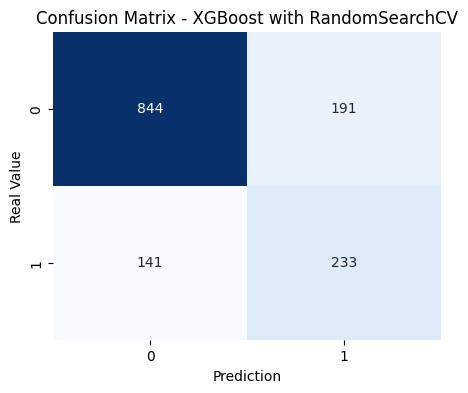

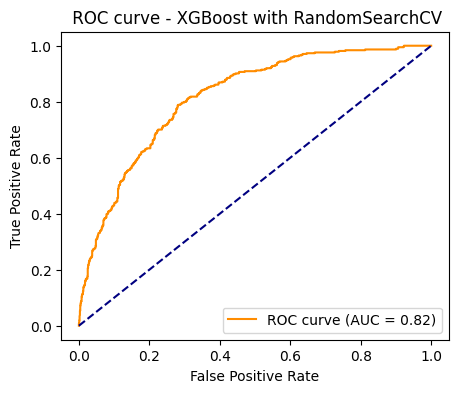

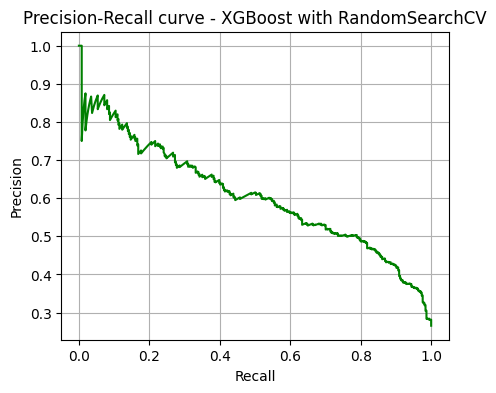

In [53]:
model_evaluation("XGBoost with RandomSearchCV", xgb_random_optimized, X_test, y_test)

In [51]:
xgb_param_grid = {
    'n_estimators': [500,600],
    'max_depth': [8,12],
    'learning_rate': [0.1, 0.15],
    'min_child_weight': [2, 4],
    'subsample': [0.9,1.0],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [2.5, 3.5],
    'reg_lambda': [1.0],
    'reg_alpha': [0],
    'random_state': [42]
}

xgb_grid_search = GridSearchCV(
    estimator= xgb_model_baseline,
    param_grid= xgb_param_grid,
    cv=5,
    scoring={
        'churn_recall': churn_recall_scorer,
        'churn_f1': churn_f1_scorer,
        'roc_auc': "roc_auc"
    },
    refit= 'churn_recall',
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(X_train_res, y_train_res)

print("\nFast Grid Search Results:")
print("Best hyperparameters:", xgb_grid_search.best_params_)
print(f"Best churn F1 score: {xgb_grid_search.best_score_:.4f}")

focused_results = xgb_grid_search.cv_results_
focused_best_idx = xgb_grid_search.best_index_

print(f"\nFocused model metrics:")
print(f"Churn Recall: {focused_results['mean_test_churn_recall'][focused_best_idx]:.4f}")
print(f"Churn F1: {focused_results['mean_test_churn_f1'][focused_best_idx]:.4f}")
print(f"ROC AUC: {focused_results['mean_test_roc_auc'][focused_best_idx]:.4f}")


xgb_grid_optimized = xgb_grid_search.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Fast Grid Search Results:
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1.0, 'scale_pos_weight': 3.5, 'subsample': 0.9}
Best churn F1 score: 0.8575

Focused model metrics:
Churn Recall: 0.8575
Churn F1: 0.8254
ROC AUC: 0.9326


model evaluation: GridSearchCV with XGBoost

Accuracy: 0.7686

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



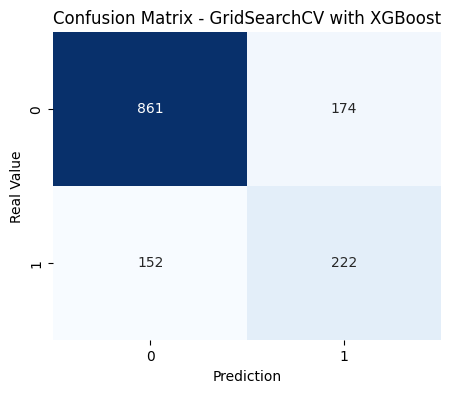

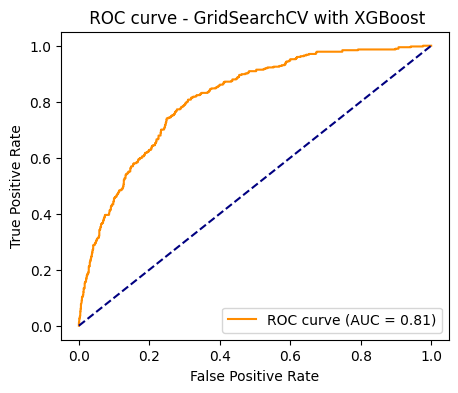

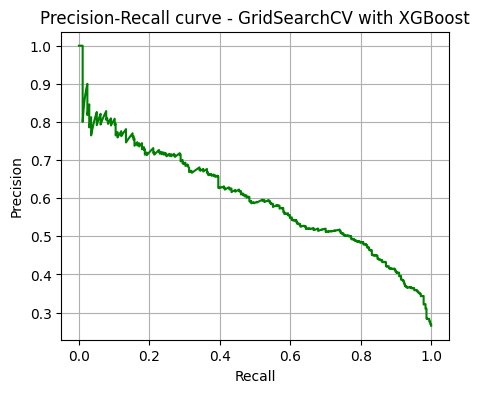

In [32]:
model_evaluation("GridSearchCV with XGBoost", xgb_grid_optimized, X_test, y_test)

In [55]:
lgbm_param = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(6, 12),
    'learning_rate': uniform(0.1, 0.15),
    'num_leaves': randint(30, 70),
    'min_child_samples': randint(15, 35),
    'subsample': uniform(0.8, 0.15),
    'colsample_bytree': uniform(0.8, 0.15),
    'reg_lambda': uniform(1, 2),
    'scale_pos_weight': uniform(1.5, 4.0),
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'random_state': [42],
    'verbose': [-1]
}

lgbm_random_search = RandomizedSearchCV(
    estimator= lgbm_model_baseline,
    param_distributions= lgbm_param,
    n_iter = 15,
    cv = 5,
    scoring = {
        'churn_f1': churn_f1_scorer,
        'churn_recall': churn_recall_scorer,
        "f1_macro": "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit= 'churn_recall',
    verbose=1,
    random_state= 42,
    n_jobs= -1
)

lgbm_random_search.fit(X_train_res, y_train_res)

print("Best hyperparameters:", lgbm_random_search.best_params_)
print(f"Best churn F1 score: {lgbm_random_search.best_score_:.4f}")

focused_results = lgbm_random_search.cv_results_
focused_best_idx = lgbm_random_search.best_index_

print(f"\nFocused model metrics:")
print(f"Churn Recall: {focused_results['mean_test_churn_recall'][focused_best_idx]:.4f}")
print(f"Churn F1: {focused_results['mean_test_churn_f1'][focused_best_idx]:.4f}")

lgbm_random_optimizied = lgbm_random_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'boosting_type': 'gbdt', 'colsample_bytree': np.float64(0.8586590911359862), 'learning_rate': np.float64(0.12733541316820934), 'max_depth': 9, 'min_child_samples': 16, 'n_estimators': 253, 'num_leaves': 33, 'objective': 'binary', 'random_state': 42, 'reg_lambda': np.float64(1.369708911051054), 'scale_pos_weight': np.float64(5.378338511058234), 'subsample': np.float64(0.9162699235041672), 'verbose': -1}
Best churn F1 score: 0.8814

Focused model metrics:
Churn Recall: 0.8814
Churn F1: 0.8212


model evaluation: LightGBM with RandomiziedCV

Accuracy: 0.7466

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.76      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



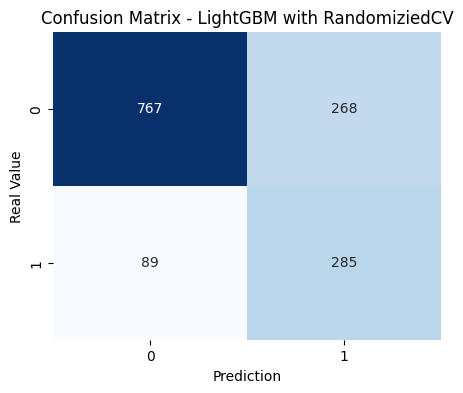

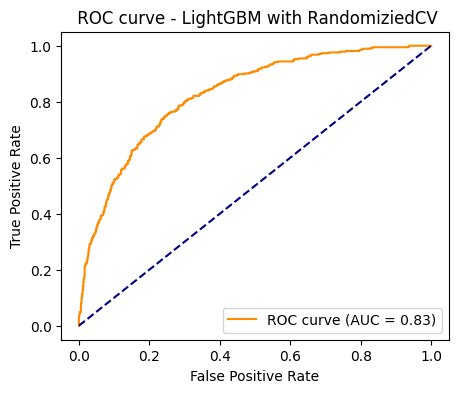

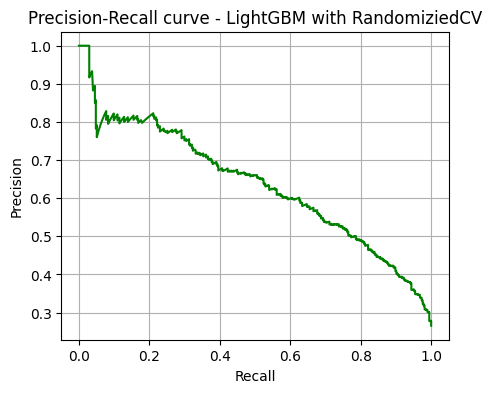

In [56]:
model_evaluation("LightGBM with RandomiziedCV", lgbm_random_optimizied, X_test, y_test)

In [49]:
lgbm_grid_param = {
    'n_estimators': [300, 500],
    'max_depth': [8, 12],
    'learning_rate': [0.1, 0.15],
    'num_leaves': [31, 70],
    'min_child_samples': [20],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_lambda': [1.0],
    'is_unbalance': [True],
    'boosting_type': ['gbdt'],
    'objective': ['binary']
}

lgbm_grid_search = GridSearchCV(
    estimator= lgbm_model_baseline,
    param_grid= lgbm_grid_param,
    cv = 5,
    scoring= {
        'churn_f1': churn_f1_scorer,
        'churn_recall': churn_recall_scorer,
        "f1_macro": "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit= 'churn_recall',
    verbose=2,
    n_jobs= -1
)

lgbm_grid_search.fit(X_train_res, y_train_res)
lgbm_grid_optimizied = lgbm_grid_search.best_estimator_


print("Best hyperparameters:", lgbm_grid_search.best_params_)
print(f"Best churn F1 score: {lgbm_grid_search.best_score_:.4f}")

grid_results = lgbm_grid_search.cv_results_
best_idx = lgbm_grid_search.best_index_

print(f"\nFocused model metrics:")
print(f"Churn Recall: {grid_results['mean_test_churn_recall'][best_idx]:.4f}")
print(f"Churn F1: {grid_results['mean_test_churn_f1'][best_idx]:.4f}")



Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'is_unbalance': True, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31, 'objective': 'binary', 'reg_lambda': 1.0, 'subsample': 0.8}
Best churn F1 score: 0.8215

Focused model metrics:
Churn Recall: 0.8215
Churn F1: 0.8235


model evaluation: LightGBM with GridSearchCV

Accuracy: 0.7757

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.58      0.58      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



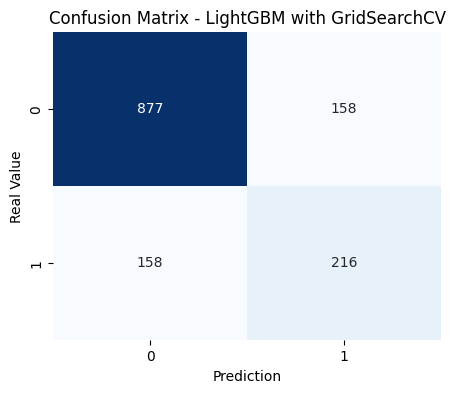

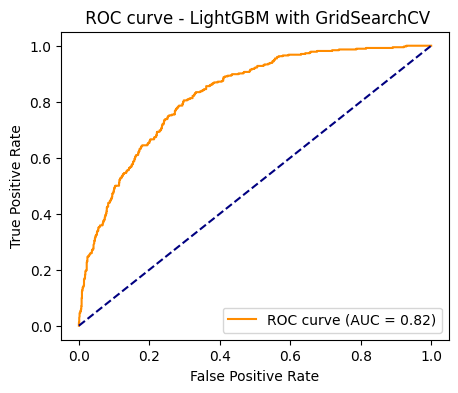

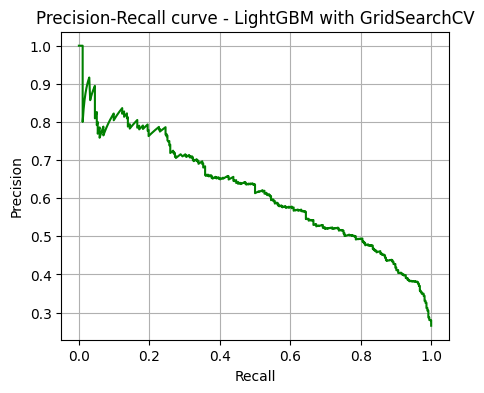

In [50]:
model_evaluation("LightGBM with GridSearchCV", lgbm_grid_optimizied, X_test, y_test)

In [70]:
param_rf_regularization = {
    'n_estimators': [300, 359, 400],  # Current: 359
    'max_depth': [4, 5, 6],  # Current: 4, try slightly deeper
    'min_samples_split': [11, 14, 17],  # Current: 11, try higher values
    'min_samples_leaf': [8, 10, 12],  # Current: 6, try higher values
    'bootstrap': [False, True],  # Current: False, try both
    'max_features': ['sqrt'],  # Add feature sampling
    'random_state': [42],
    'class_weight': ['balanced']  # Try different weights
}

rf_regularization_search = GridSearchCV(
    estimator=rf_model_baseline,
    param_grid=param_rf_regularization,
    cv=5,
    scoring={
        'churn_recall': churn_recall_scorer,
        'churn_precision': churn_precision_scorer,
        'churn_f1': churn_f1_scorer,
        'f1_weighted': "f1_weighted",
        'precision_macro': "precision_macro"
    },
    refit='churn_precision',  # Focus on precision to reduce FP
    verbose=2,
    n_jobs=-1
)

rf_regularization_search.fit(X_train_res, y_train_res)

rf_reg_optimize = rf_regularization_search.best_estimator_

print("Best hyperparameters:", rf_regularization_search.best_params_)
print(f"Best churn F1 score: {rf_regularization_search.best_score_:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 11, 'n_estimators': 300, 'random_state': 42}
Best churn F1 score: 0.8001


model evaluation: rf_regularization

Accuracy: 0.7665

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409



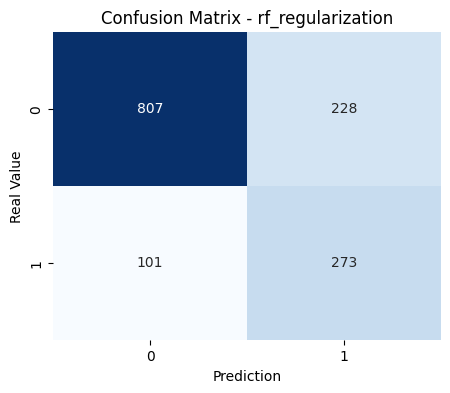

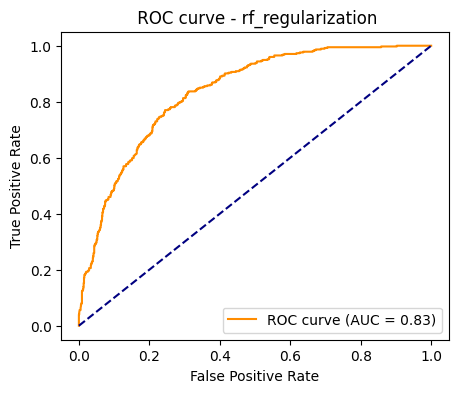

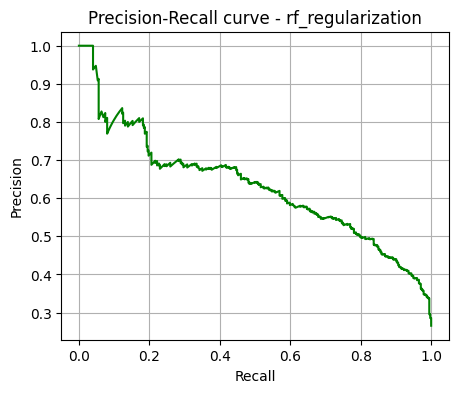

In [71]:
model_evaluation("rf_regularization", rf_reg_optimize, X_test, y_test)

In [59]:
for param , val in lgbm_random_search.best_params_.items():
    print(f"{param}:{val}")

boosting_type:gbdt
colsample_bytree:0.8586590911359862
learning_rate:0.12733541316820934
max_depth:9
min_child_samples:16
n_estimators:253
num_leaves:33
objective:binary
random_state:42
reg_lambda:1.369708911051054
scale_pos_weight:5.378338511058234
subsample:0.9162699235041672
verbose:-1


In [1]:
manual_param = {
    'n_estimators': [240,300],
    'learning_rate': [0.12,0.15],
    'max_depth': [10,15],
    'min_child_samples': [16,20],
    'num_leaves': [33,40],
    'subsample': [0.8,0.9],
    'scale_pos_weight': [5.1,6.0],
    'colsample_bytree': [0.8],
    'objective': ['binary'],
    'reg_alpha': [0.1],
    'reg_lambda': [1.5],
    'verbose': [-1],
    'boosting_type': ['gbdt'],
    'random_state': [42]
}

lgbm_manual_search = GridSearchCV(
    estimator= lgbm_model_baseline,
    param_grid= manual_param,
    cv = 5,
    scoring= {
        'churn_recall': churn_recall_scorer,
        'churn_precision': churn_precision_scorer,
        'churn_f1': churn_f1_scorer,
        'f1_weighted': "f1_weighted",
        'precision_macro': "precision_macro",
    },
    refit= 'churn_f1',
    verbose=2,
    n_jobs= -1
)

lgbm_manual_search.fit(X_train_res, y_train_res)
lgbm_reg_optimized = lgbm_manual_search.best_estimator_



NameError: name 'GridSearchCV' is not defined

model evaluation: Lgbm

Accuracy: 0.7537

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1035
           1       0.53      0.68      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409



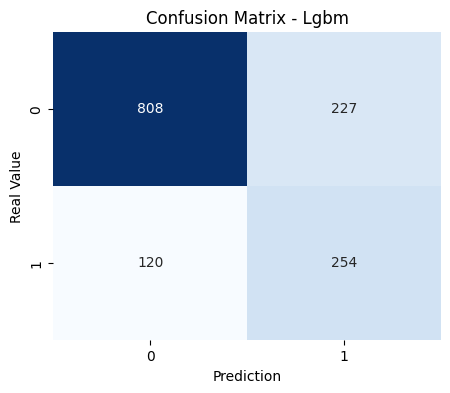

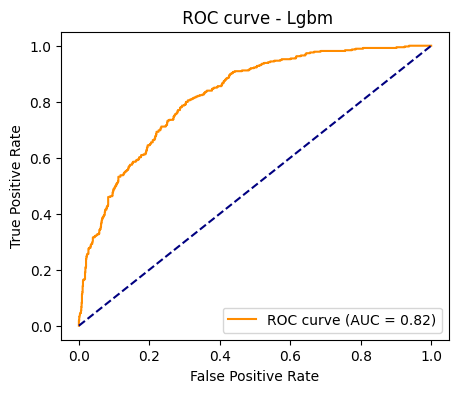

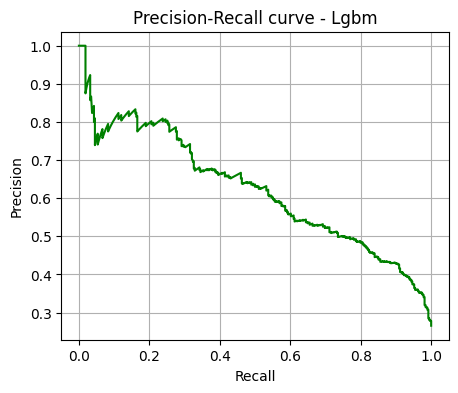

In [73]:
model_evaluation("Lgbm", lgbm_reg_optimized, X_test, y_test)

In [67]:
print(lgbm_manual_search.best_params_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.12, 'max_depth': 10, 'min_child_samples': 16, 'n_estimators': 240, 'num_leaves': 33, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'scale_pos_weight': 6.0, 'subsample': 0.8, 'verbose': -1}
